<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Zeunerstraße 38, 01069 Dresden, Germany
</span>

---

# Condition Monitoring of Drive Trains by Data Fusion of Acoustic Emission and Vibration Sensors

### Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Dirk Mayer, Christian Schmidt, Samuel Klein and Hans-Georg Herrmann

---

## Notebook *FeatureExtraction_02_VB_AE_WelchPowerSpectralDensity*

This notebook demonstrates the feature extraction of the measured vibration and acoustic emission signals. For four measurements (one for each failure category) the measured samples for the rotation speed 1000rpm are selected. Then the vibration data is filtered using Bessel and Wiener filters. Finally for both, the (filtered) vibration as well as the acoustic emission signals the *Welch Power Spectral Density* is calculated.  

---

<span style="color:gray">
Version: 1.0.2 (May 31, 2021) <br>
Authors: André Schneider, Oliver Mey 
 </span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy as np
import pandas as pd
import urllib, json
import seaborn as sns
import colorcet as cc
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from glob import glob
from itertools import chain
from scipy.signal import welch
from scipy.signal import bessel, filtfilt

sns.set(rc={'figure.figsize':(16, 4)})

In [2]:
project = 'SkaliSens_07'
experiment = 'FeatureExtraction_02'
approach = 'VB_AE_WelchPowerSpectralDensity'
revision = '$Id$'

## Configuration

The *path* must specify the directory into which the Fordatis data set was downloaded and unpacked. With *mask* a subset of measurements can be configured using a regular expression (e.g. all measurements starting with *3*).

For the demonstration of feature extraction the four measurements *'3008_N0D2', '1006_I3D2', '1010_O3L1', '1015_B3D2'* are selected by using *masks*. Furthermore, samples for the speed 1000rpm are selected by using the configuration parameter *speed*.

In [3]:
path = 'fordatis'
masks = ['3008_N0D2', '1006_I3D2', '1010_O3L1', '1015_B3D2']
speeds = [1000]
labels = ['None', 'Inner', 'Outer', 'Balls']
categories = ['No defect', 'Inner ring defect', 'Outer ring defect', 'Rolling element defect']
sensors = ['vb', 'ae']
frame = 16
frequencies = [8192.0, 390625.0]
crop = [[10.0, 2000.0], [512.0, 50.0e3]]
f_vb = np.linspace(0.0, frequencies[0]/2,4097)
f_ae = np.linspace(0.0, frequencies[1]/2,4001)
i1 = np.argwhere(f_vb >= crop[0][0])[0][0]
i2 = np.argwhere(f_vb <= crop[0][1])[-1][0]
inputs_vb = i2 - i1 + 1
crop_vb = [slice(None, None),slice(i1, i2)]
i1 = np.argwhere(f_ae >= crop[1][0])[0][0]
i2 = np.argwhere(f_ae <= crop[1][1])[-1][0]
inputs_ae = i2 - i1 + 1
crop_ae = [slice(None, None),slice(i1, i2)]
t_vb = np.linspace(0, 1e9, 8192)
t_ae = np.linspace(0.0, 20.48e6, 8000)
crops = {'vb':crop_vb, 'ae':crop_ae}

## Function definitions

Among other helper functions for loading and preprocessing data the filter functions (Bessel, Wiener filters) and the function for calculation of the Welch Power Spectral Density are defined in this section.

In [4]:
def setup(path, masks):
    files = [sorted(glob(path + '/data/' + mask)) for mask in masks]
    files = list(chain(*files))
    measurements = [os.path.basename(str(file)) for file in files]
    descriptors = [pd.read_json(path + '/measurements/' + measurement + '.json') 
                   for measurement in measurements]
    usecases = [labels.index(descriptor.loc['usecasegroup', 'measurement']) 
                for descriptor in descriptors]
    return measurements, usecases

def load_time_ranges(path, measurements, speeds):
    w = [load_samples(path, measurement, sensor='w') for measurement in measurements]
    for wi in w: wi.columns = ['w']
    t_ranges = [[wi[wi['w'] == speed].index.to_numpy() for speed in speeds] for wi in w]
    return t_ranges

def get_time_range(t, speed=600):
    return t[speeds.index(speed)][0], t[speeds.index(speed)][1]

def load_samples(path, measurement, sensor):
    samples = pd.read_csv(path + '/data/' + measurement + '/' + sensor + '.csv', 
                   parse_dates=[0], index_col=0, sep=' ', header=None)
    samples.index = samples.index.values.astype('datetime64[us]')
    return samples

def synchronize(X, P=None):
    X1_ = X[1][X[1].index.ceil('s').isin(X[0].index)]
    X0_ = X[0][X[0].index.isin(X1_.index.ceil('s'))]
    return [X0_, X1_]

def select(X, P=None):
    p = P[0]
    x = X[1].groupby(X[1].index.ceil('s')).nth([0, p['frame']])
    x = x.groupby(x.index.ceil('s')).last()
    return [X[0], x]

def shrink(X, P):
    I = range(len(P))
    t_ranges = [[get_time_range(p['t_ranges'], speed=speed) for speed in p['speeds']] for p in P]
    X_ = [pd.concat([x[x.index.to_series().between(t[0], t[1])] for t in t_ranges[i]]) for x,i in zip(X,I)]
    return X_

def fft(X, P=None):
    X = [pd.DataFrame(np.abs(np.fft.rfft(x))) for x in X]
    for x in X: x[0]=0
    return X

def kurtosis(X, P=None):
    X = [pd.DataFrame(sc.stats.kurtosis(x)) for x in X]
    return X

def skewness(X, P=None):
    X = [pd.DataFrame(sc.stats.skew(x)) for x in X]
    return X

def bessel_(X, P=None):
    b, a = bessel(N=4, Wn=5, btype='highpass', analog=False, norm='phase', fs=frequencies[0])
    x = X[0].copy()
    x = filtfilt(b,a,x.values.flatten()).reshape(-1, int(frequencies[0]))
    x = pd.DataFrame(x)
    return [x, X[1]]

def fir_(y, u, nb):
    N = y.size - nb -1
    phi = np.zeros(nb)
    PHI = np.zeros((N, nb))
    for i in range(N):
        phi[0:nb] = u[nb+i:i:-1]
        PHI[i, :] = phi
    W = np.dot(np.linalg.pinv(PHI.T @ PHI), PHI.T @ y[nb+1:])
    return W

def wiener_(df, f_remove, fps, duration, A=1, order=2):
    t = np.linspace(0,duration, int(fps*duration))
    X = df.values
    for fc in f_remove:
        for i in range(X.shape[0]):
            u = A * np.sin(2 * np.pi * fc * t / duration)
            W = fir_(X[i,:], u, order)
            ym = np.zeros(order)
            yout  = np.zeros_like(X[i,:])
            for k, _ in enumerate(u):
                yout[k] = np.dot(W, ym)
                ym = np.hstack((np.array(u[k]), ym[0:-1]))
            X[i,:]=X[i,:] - yout
    df_out = df.copy()
    df_out.iloc[:,:] = X
    return df_out

def wiener(X, P=None):
    x = X[0].copy()
    f_remove = [50, 100, 200, 300, 400, 500]
    duration = 1.0
    x = wiener_(x, f_remove, frequencies[0], duration)
    return [x, X[1]]

def welch_(X, P=None):
    x0 = X[0].values.flatten()
    x1 = X[1].values.flatten()
    x0 = welch(x0, frequencies[0], window="hamming", nperseg= int(frequencies[0]), scaling="spectrum")
    x1 = welch(x1, frequencies[1], window="hamming", nperseg=X[1].shape[1], scaling="spectrum", noverlap=0)
    x0 = pd.DataFrame(x0[1], index=x0[0])
    x1 = pd.DataFrame(x1[1], index=x1[0])
    return [x0,x1]

def crop(X, P=None):
    crops = [(p['rows'], p['columns']) for p in P]
    X = [x.iloc[crop] for x,crop in zip(X,crops)]
    return X
    
def extract_features(X, F, P):
    for f in F: X = [f(x,p) for x,p in zip(X,P)]
    return X

def plot(X_t, X_p, measurement):
    plt.figure(figsize=(16,6))
    ax1 = plt.subplot(221)
    ax1.plot(t_vb/1e9, X_t[0].iloc[10,:], alpha=0.7, color='b')
    ax1.set_ylim(-1, 1)
    ax1.set_title(measurement + ': Vibration sample (time domain)', fontweight='bold')
    ax1.set_xlabel('time in s')
    ax1.set_ylabel('vibration')
    ax2 = plt.subplot(222)
    X_p[0].plot(ax=ax2, logy=True, xlim=(0,4e3), ylim=(1e-11, 1e-3), alpha=0.8, color='g', legend=False)
    ax2.set_title(measurement + ': Welch power spectral density of Vibration', fontweight='bold')
    ax2.set_xlabel('frequency in Hz')
    ax2.set_ylabel('power density')
    ax3 = plt.subplot(223)
    ax3.plot(t_ae/1e6, X_t[1].iloc[10,:], alpha=0.7, color='r')
    ax3.set_ylim(-4e4, 4e4)
    ax3.set_title(measurement + ': Acoustic Emission sample (time domain)', fontweight='bold')
    ax3.set_xlabel('time in ms')
    ax3.set_ylabel('acoustic emission')
    ax4 = plt.subplot(224)
    X_p[1].plot(ax=ax4, logy=True, xlim=(0,80e3), ylim=(1e0, 1e7), alpha=0.8, color='g', legend=False)
    ax4.set_title(measurement + ': Welch power spectral density of Acoustic Emission', fontweight='bold')
    ax4.set_xlabel('frequency in Hz')
    ax4.set_ylabel('power density')
    plt.tight_layout()
    plt.show()
    return

## Loading and preprocessing of data

In [5]:
measurements, usecases = setup(path, masks)
t_ranges = load_time_ranges(path, measurements, speeds)
parameters = [[dict([('t_ranges', t), ('rows', crops[sensor][0]), ('columns', crops[sensor][1]),
           ('frame', frame), ('speeds', speeds)]) for sensor in sensors] for t in t_ranges]

In [6]:
samples = [[load_samples(path, measurement, sensor) for sensor in sensors] for measurement in measurements]

## Feature extraction

In [7]:
X_t = extract_features(samples, [shrink, synchronize, select, bessel_, wiener], parameters)
X_p = extract_features(X_t, [welch_], parameters)

## Plotting of timeseries and power spectrums for Vibration and Acoustic Emission signals

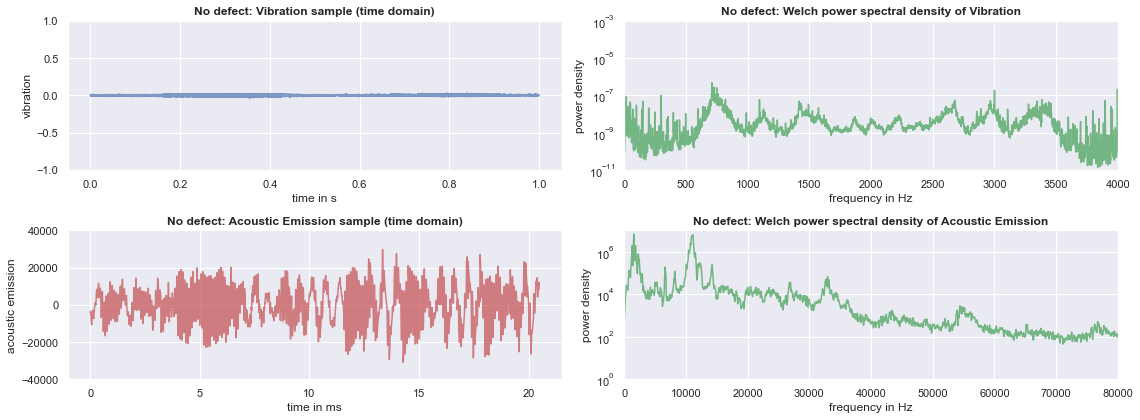

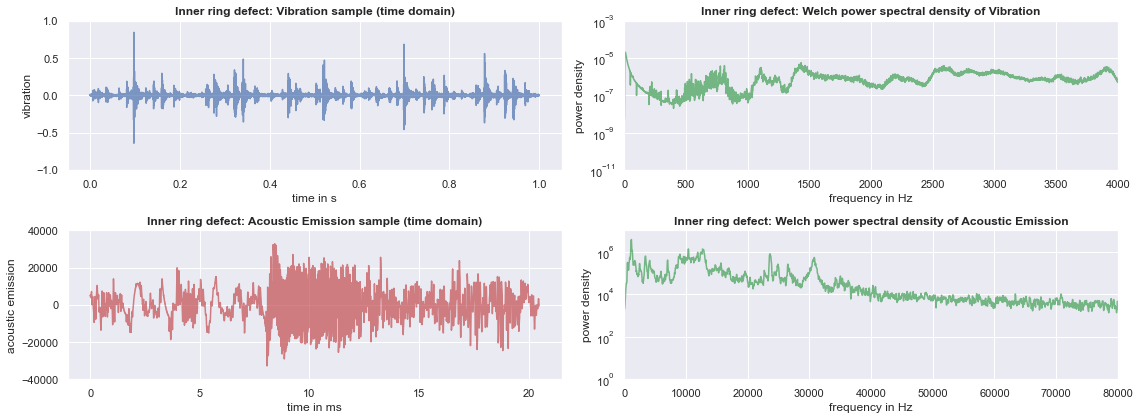

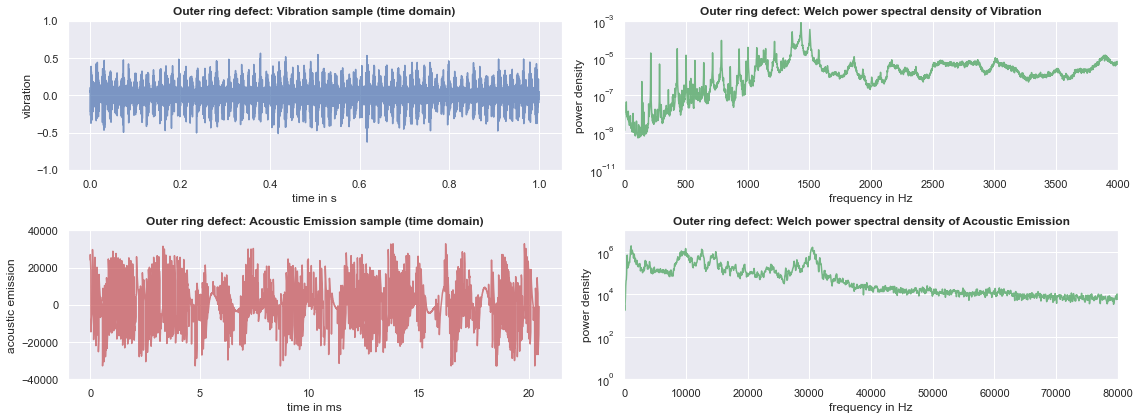

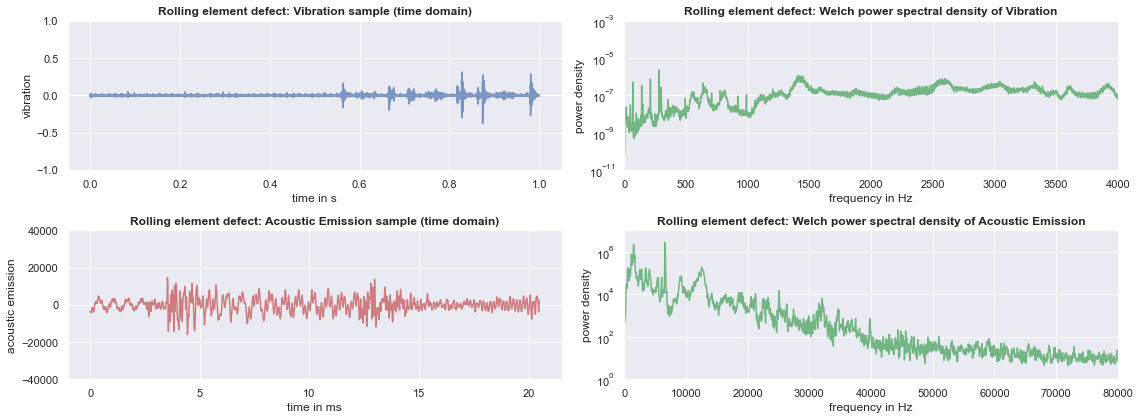

In [8]:
_ = [plot(x_t, x_p, m) for x_t, x_p, m in zip(X_t, X_p, categories)]